 ## 15/03/2021 
Synthetic data generation 

This is the code for generating the synthetic audio for the normal audio augmented with various noise data. 

previously it was described that the np paper complex model would require some various machine noises, which contain synthetic samples of audio containing train operating noises and a sample of an object dropping. 

This section will do that, with a similar technique from before, when the void samples were generated. 



In [1]:
import librosa 
import librosa.display
import cv2
import IPython.display as idp
import matplotlib.pyplot as plt 
import numpy as np 


In [2]:
# load the normal operation sound 
audio, sr = librosa.load("./data/youtube/wav/7_normal.wav")
data = audio[50*sr:60*sr]
idp.Audio(data, rate =sr)

## 16/03/2021 

motivation for the mel- spectrogram: 

stft takes frames of an audio and applies a window to it, and converts to the frequency domain. stacking them side by side gives a spectrogram. Humans do not perceive frequencies on a linear scale, as we are better at detecting differences in lower frequencies than higher. E.g we can tell between 500/1000 Hz but we cannot tell between 10,000 and 10,500.  

There was a 1937 paper outlining the mel scale, which results in an equally distant decomposition to the litsener. We can argue that this is suitable as firstly the interraction noise was said to be audible, secondly the frequencies proposed by james are all in the lower frequency region. 


First, a sample of the nornmal operation sound is sampled

Jame's frequencies are: 
 [[106 168 193 303 495 753]
 [140 168 204 305 501 756]
 [168 168 200 309 498 757]
 [143 168 195 313 499 756]
 [106 168 194 303 493 755]]
The frequenceis in the spectrus are: 
 [   0.            8.05509645   16.1101929    24.16528936   32.22038581
   40.27548226   48.33057871   56.38567517   64.44077162   72.49586807
   80.55096452   88.60606097   96.66115743  104.71625388  112.77135033
  120.82644678  128.88154324  136.93663969  144.99173614  153.04683259
  161.10192904  169.1570255   177.21212195  185.2672184   193.32231485
  201.37741131  209.43250776  217.48760421  225.54270066  233.59779712
  241.65289357  249.70799002  257.76308647  265.81818292  273.87327938
  281.92837583  289.98347228  298.03856873  306.09366519  314.14876164
  322.20385809  330.25895454  338.31405099  346.36914745  354.4242439
  362.47934035  370.5344368   378.58953326  386.64462971  394.69972616
  402.75482261  410.80991906  418.86501552  426.92011197  434.97520842
  443.03030487  451

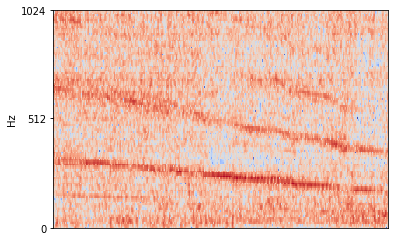

In [3]:

# f_max is the maximum frequency we would like to be looking at. Feature only present in this region. assume everything else is noise 
# we are dividing this region into 128 chuncks using the mel scale 
f_max = 1024   
n_mels = 128

# filter bank contains the most significant frequencies proposed by james for a few different voids
filter_set  = np.load("james_freqs.npy")

# visualise the mel spectrogram
Xt = librosa.power_to_db(abs(librosa.feature.melspectrogram(data, n_mels = n_mels,fmax = f_max)))
librosa.display.specshow(Xt, y_axis = "mel", fmax = f_max)
#freqs= np.arange(0, 1 + n_fft / 2) * sr / n_fft

# lists the filters 
freqs = librosa.mel_frequencies(n_mels = n_mels, fmax = f_max)

print("Jame's frequencies are: \n", filter_set)
print("The frequenceis in the spectrus are: \n", freqs)

In [8]:
# this first one is not used. 
def augment_with_features(x,b,n_mels= n_mels, f_max = f_max):
    xt = librosa.feature.melspectrogram(x,n_mels = n_mels,fmax = f_max)
    locs = []
    print(xt.shape)
    print(b.shape)
    for i in range(5):
        loc = np.random.randint(0,xt.shape[1]-b.shape[1])
        xt[:,loc:loc+b.shape[1]] += b
        locs.append(loc)
        
    return librosa.feature.inverse.mel_to_audio(xt,fmax = f_max), xt, locs


# this superimposes the time domain signal of the sound with a randomly selected segment in the background sound. 
def augment_time(x,feature, scale,n=5):
    locs = []
    x = librosa.util.normalize(x)
    if len(feature) >= len(x):
        feature = feature[:len(x)-5]
    feature = librosa.util.normalize(feature)* scale 
    
    # this is how many we are putting in 
    for i in range(n):
        
        # select random location
        loc = np.random.randint(0,len(x)-len(feature))
        # superposition
        x[loc:loc+len(feature)] += feature 
        locs.append(loc)
        
    # the returned audio is normalised 
    return librosa.util.normalize(x), locs
    

## 17/03/2021 

Samples of random objects dropping are superposed onto the normal operation sound and saved as samples of various machine sounds. 

In [9]:
newsound,locs = augment_time(data,feature_audio,0.7)
print(max(newsound), min(newsound))
idp.Audio(newsound, rate=sr)

1.0 -0.8837124


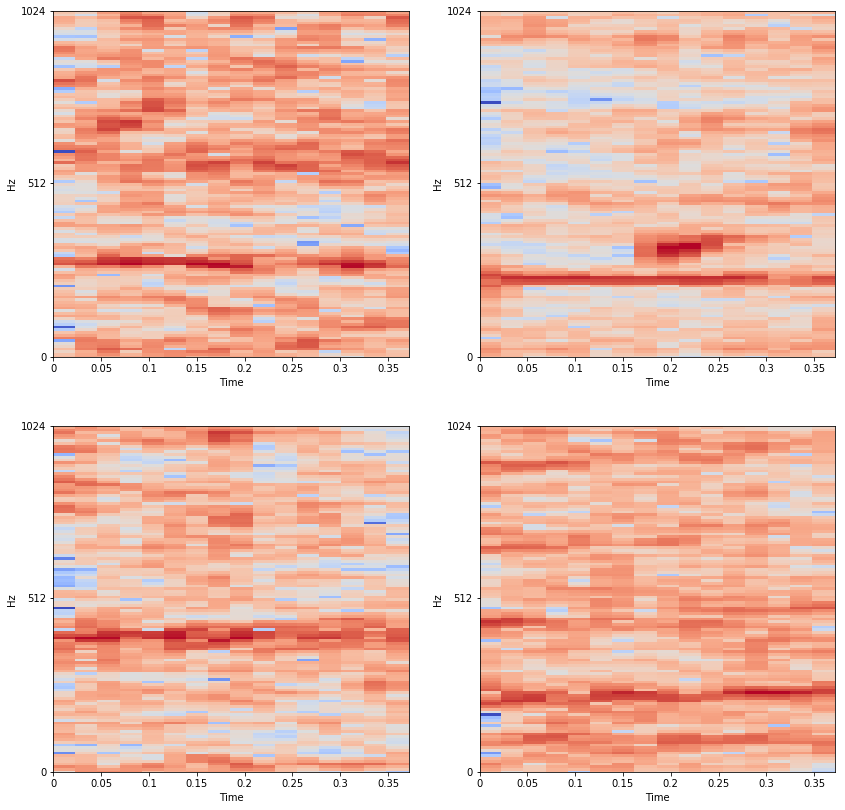

In [14]:
import os 
import soundfile as sf

def create_various_sound(normal_sound,n, verbose = False, clip_len = 16):
    # This generates normal sounding data slices. hopefully these can be distinguished from the 
    # abnormal set. 
    # We can use this to actually test supervised learning methods as well
    
    save_path = "./data/synthetic/various_sounds/various/"
    noise_dir = "./data/various/"
    dir_list = os.listdir(noise_dir)
    x_list = []
    n_frames=clip_len*512-1
    for i in range(n):
        loc = np.random.randint(0,len(normal_sound)-n_frames)
        normal_slice = normal_sound[loc:loc+n_frames]
        
        noise = np.random.choice(dir_list)
        noise_sound, _ = librosa.load(noise_dir + noise)

        output_sound,_ = augment_time(normal_slice,noise_sound,2,1)
        sf.write(save_path+"n"+str(i)+".wav", output_sound, sr, subtype='PCM_24')
        if i <4: 
            x_list.append(output_sound)
        
    if verbose: 
        fig, axs = plt.subplots(2,2, figsize = (14,14))
        for j in range(len(x_list)):
            x1 = x_list[j]
            xt = librosa.power_to_db(abs(librosa.feature.melspectrogram(x1, n_mels = n_mels,fmax = f_max)))
            librosa.display.specshow(xt, y_axis = "mel", x_axis = "time", fmax = f_max, ax = axs[j//2][j%2])  
    return 

create_various_sound(audio,1000,verbose=True)


    

In [12]:
import os
noise_dir = "./data/various"
dir_list = os.listdir(noise_dir)
dir_list

['1.wav',
 '10.wav',
 '11.wav',
 '12.wav',
 '13.wav',
 '14.wav',
 '15.wav',
 '16.wav',
 '17.wav',
 '18.wav',
 '19.wav',
 '2.wav',
 '20.wav',
 '21.wav',
 '22.wav',
 '3.wav',
 '4.wav',
 '5.wav',
 '6.wav',
 '7.wav',
 '8.wav',
 '9.wav']